2025-05-20 21:03:18.379451: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-20 21:03:18.385696: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-20 21:03:18.402863: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747789398.432446  102281 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747789398.446940  102281 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747789398.470848  102281 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Epoch 20/200 | D_loss: 0.8259 | G_loss: 0.2914
Epoch 40/200 | D_loss: 1.4632 | G_loss: 0.1608
Epoch 60/200 | D_loss: 1.9388 | G_loss: 0.1090
Epoch 80/200 | D_loss: 2.2720 | G_loss: 0.0824
Epoch 100/200 | D_loss: 2.5044 | G_loss: 0.0663
Epoch 120/200 | D_loss: 2.6769 | G_loss: 0.0554
Epoch 140/200 | D_loss: 2.8194 | G_loss: 0.0477
Epoch 160/200 | D_loss: 2.9456 | G_loss: 0.0418
Epoch 180/200 | D_loss: 3.0506 | G_loss: 0.0373
Epoch 200/200 | D_loss: 3.1421 | G_loss: 0.0336


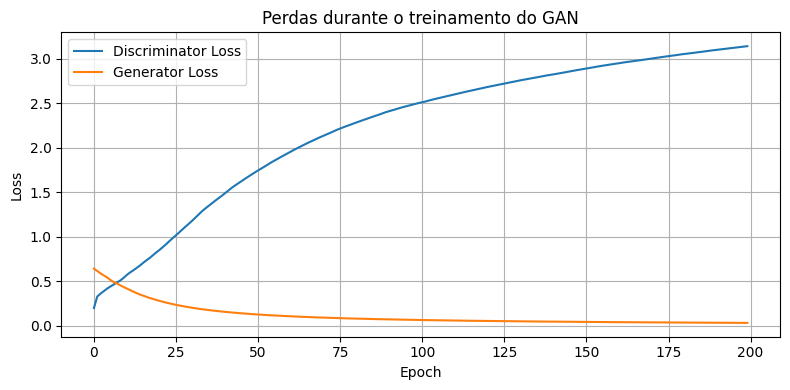

In [1]:
# ✅ GAN corrigido com saída linear no Generator + Reescalonamento para RSSI

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Input
import matplotlib.pyplot as plt

# ================================
# 1. Dados reais de entrada (X_real)
# ================================
df_real = pd.read_csv("/home/darkcover/Documentos/Gan/Data/df_simulated.csv")
X_real = df_real.iloc[:, :10].values.astype(np.float32)

n_features = X_real.shape[1]  # 10 WAPs
latent_dim = n_features       # 10

# ================================
# 2. Generator com saída linear
# ================================
def build_generator():
    model = Sequential([
    Input(shape=(latent_dim,)),
    layers.Dense(10, activation='relu'),
    layers.Dense(n_features) # saída linear
    ])
    return model

# ================================
# 3. Discriminator padrão
# ================================
def build_discriminator():
    model = Sequential([
        Input(shape=(n_features,)),
        layers.Dense(10, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# ================================
# 4. Compilar modelos
# ================================
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01))

discriminator.trainable = False

gan_input = Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = tf.keras.Model(gan_input, gan_output)
gan.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.01))

# ================================
# 5. Loop de Treinamento GAN
# ================================
epochs = 200
batch_size = 64
half_batch = batch_size // 2
d_losses, g_losses = [], []

for epoch in range(epochs):
    idx = np.random.randint(0, X_real.shape[0], half_batch)
    real_samples = X_real[idx]
    real_labels = np.ones((half_batch, 1))

    noise = np.random.uniform(-1, 1, (half_batch, latent_dim))
    fake_samples = generator.predict(noise, verbose=0)
    fake_labels = np.zeros((half_batch, 1))

    d_loss_real = discriminator.train_on_batch(real_samples, real_labels)
    d_loss_fake = discriminator.train_on_batch(fake_samples, fake_labels)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)

    noise = np.random.uniform(-1, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch(noise, valid_y)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs} | D_loss: {d_loss:.4f} | G_loss: {g_loss:.4f}")

# ================================
# 6. Plotar perdas
# ================================
plt.figure(figsize=(8, 4))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Perdas durante o treinamento do GAN")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
# Salvar Generator e Discriminator
generator.save("/home/darkcover/Documentos/Gan/Models/Modelsgenerator.h5")
discriminator.save("/home/darkcover/Documentos/Gan/Models/Modelsdiscriminator.h5")
print("✅ Generator e Discriminator salvos em models/")


✅ Generator e Discriminator salvos em models/


In [3]:
# ======= Geração de 10 blocos de 4.000 (mais diversidade) =======
generated_all = []
min_val, max_val = -5, 6  # baseado na saída bruta

for _ in range(10):
    noise = np.random.uniform(-1, 1, size=(4000, latent_dim))
    raw = generator.predict(noise, verbose=0)
    scaled = (raw - min_val) / (max_val - min_val)
    clipped = scaled * 70 - 110
    generated_all.append(clipped)

generated_rssi = np.vstack(generated_all)
columns = [f'WAP{str(i+1).zfill(3)}' for i in range(n_features)]
df_generated = pd.DataFrame(generated_rssi, columns=columns)
df_generated = df_generated.clip(-110, -40).astype(int)
df_generated.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated.csv", index=False)
print("✅ df_generated.csv salvo com sucesso com 40.000 amostras mais diversas")

✅ df_generated.csv salvo com sucesso com 40.000 amostras mais diversas


In [4]:
df_generated.describe()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,-52.131000,-97.930100,-60.247600,-89.294925,-63.500625,-94.420700,-70.493825,-97.648175,-93.546025,-67.002625
std,4.353879,5.075836,4.681441,4.961357,3.109902,5.060805,2.509307,5.459940,3.898392,4.002002
min,-64.000000,-110.000000,-71.000000,-110.000000,-72.000000,-110.000000,-79.000000,-110.000000,-110.000000,-78.000000
25%,-55.000000,-101.000000,-64.000000,-93.000000,-66.000000,-98.000000,-72.000000,-101.000000,-96.000000,-70.000000
50%,-53.000000,-98.000000,-61.000000,-89.000000,-64.000000,-94.000000,-71.000000,-97.000000,-93.000000,-67.000000
75%,-49.000000,-94.000000,-57.000000,-86.000000,-62.000000,-91.000000,-69.000000,-93.000000,-91.000000,-64.000000
max,-40.000000,-82.000000,-40.000000,-78.000000,-46.000000,-80.000000,-60.000000,-85.000000,-82.000000,-50.000000


In [5]:
df_generated.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010
0,-54,-94,-60,-97,-60,-100,-71,-96,-97,-71
1,-53,-95,-58,-96,-64,-94,-70,-94,-93,-72
2,-56,-94,-58,-95,-64,-93,-73,-96,-91,-73
3,-44,-104,-63,-92,-61,-100,-69,-101,-97,-61
4,-54,-101,-60,-87,-66,-101,-71,-91,-91,-70


In [6]:

df_generated.to_csv("/home/darkcover/Documentos/Gan/Data/df_generated.csv", index=False)
print("✅ df_generated.csv salvo com sucesso com RSSI reescalonado")


✅ df_generated.csv salvo com sucesso com RSSI reescalonado
